In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/huggingface/diffusers
!pip install accelerate wand
!pip install -r https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/requirements.txt

!accelerate config default

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-nd5ipa2r
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-nd5ipa2r
  Resolved https://github.com/huggingface/diffusers to commit 80fd9260bb12911bc702ab2886971a89b45399fc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.33.0.dev0-py3-none-any.whl size=3231036 sha256=7b584910dc3028e737a8c03e530e370624aed3f2e35d9182ca0e578271f3d71d
  Stored in directory: /tmp/pip-ephem-wheel-cache-bri0r00o/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.31.0
    Uninstalling diffusers-0.31.0:
      Successfully uninstalled diffusers-0.31.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 2.9 MB/s et

In [3]:
import os
import safetensors.torch
from diffusers import DiffusionPipeline, UNet2DConditionModel
from diffusers.models.lora import LoRACompatibleLinear
from peft import LoraConfig
import torch
from accelerate import Accelerator
from diffusers.utils.torch_utils import is_compiled_module

In [4]:
    saved_model_dir = '/content/drive/MyDrive/pathmnist/generation_model/checkpoint-1000/'

    accelerator = Accelerator() # (mixed_precision=None)

    unet = UNet2DConditionModel.from_pretrained('stable-diffusion-v1-5/stable-diffusion-v1-5', subfolder="unet")
    unet.requires_grad_(False)
    unet_lora_config = LoraConfig(
        r=4,
        lora_alpha=4,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    unet.add_adapter(unet_lora_config)
    unet = accelerator.prepare(unet)

    pipeline = DiffusionPipeline.from_pretrained(
       saved_model_dir,
       unet=unet,
       torch_dtype=torch.float32,
    ).to("cuda")
    pipeline.safety_checker = None
    pipeline.requires_safety_checker = False

    # Load the accelerator state (this is essential line as it turns out!!!)
    accelerator.load_state(saved_model_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

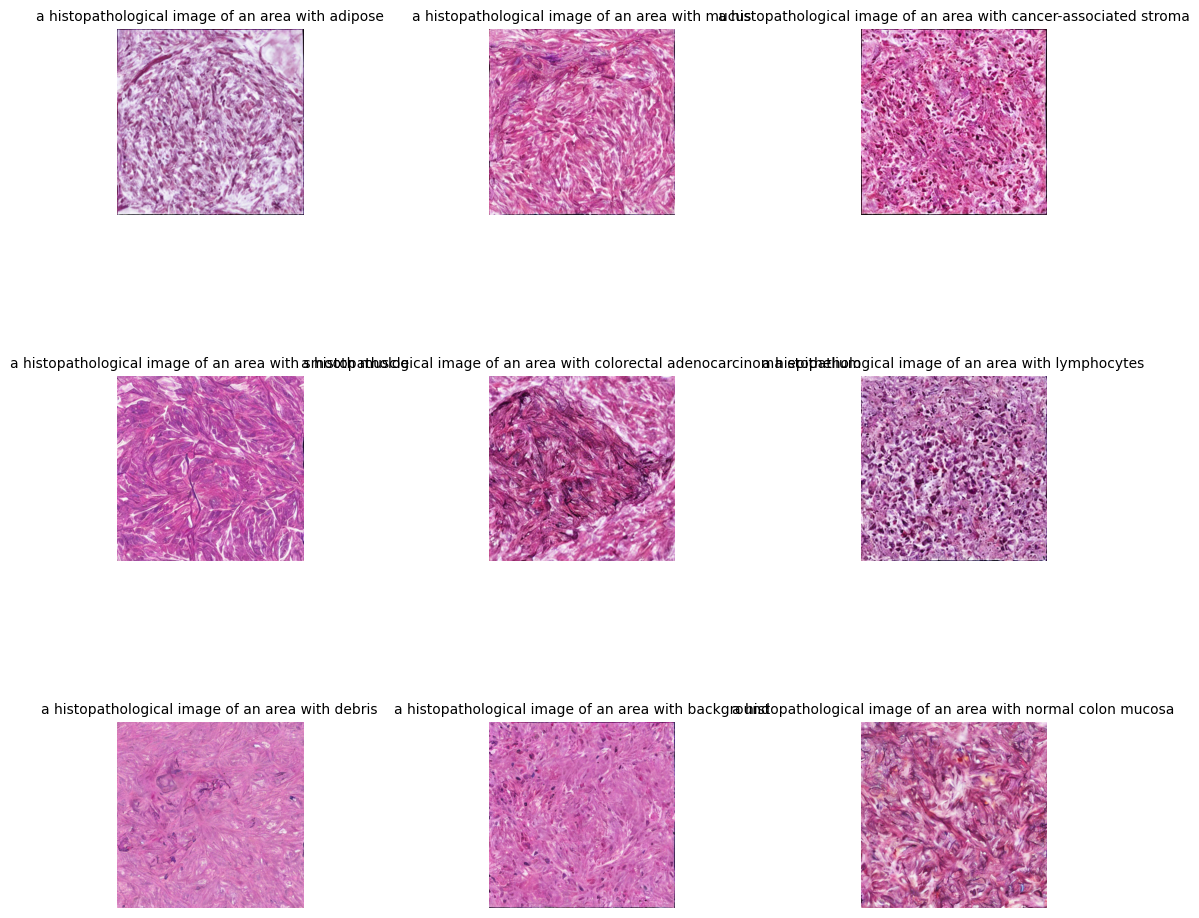

In [6]:
from IPython.display import display
import matplotlib.pyplot as plt

'''
prompts=["a histopathological image of an area with cancer-associated stroma",
          "a histopathological image of an area with smooth muscle",
          "a histopathological image of an area with background"]

prompts=["a histopathological image of an area with adipose",
          "a histopathological image of an area with mucus",
          "a histopathological image of an area with normal colon mucosa"]
'''
prompts=["a histopathological image of an area with adipose",
          "a histopathological image of an area with mucus",
          "a histopathological image of an area with cancer-associated stroma",
          "a histopathological image of an area with smooth muscle",
          "a histopathological image of an area with colorectal adenocarcinoma epithelium",
          "a histopathological image of an area with lymphocytes",
          "a histopathological image of an area with debris",
          "a histopathological image of an area with background",
          "a histopathological image of an area with normal colon mucosa"]
'''
image = pipeline(prompt="a histopathological image of an area with adipose").images[0]
width, height = image.size
image = image.resize((int(width / 2), int(height / 2)))
display(image)
'''

fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid, larger figure size

for i, prompt in enumerate(prompts):
    image = pipeline(prompt).images[0]
    row = i // 3  # Calculate row index for 3x3 grid
    col = i % 3   # Calculate column index for 3x3 grid
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(prompt, fontsize=10)

plt.subplots_adjust(wspace=1, hspace=0.5)  # Adjust spacing for 3x3 grid
plt.show()